<a href="https://colab.research.google.com/github/ahmadizza/Convolutional-Neural-Network-CNN-for-CIFAR-10-Classification/blob/main/RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projek UTS Deep Learning**

## **Kelompok 2:**
*   Ahmad Izza - 11220940000006
*   Ahmad Fauzan - 11220940000031

## **Bagian CNN**


*Untuk cnn ada di notebook terpisah:*
*   Link cnn: https://colab.research.google.com/drive/1UAJJyMAXmYX8z5Pt9w-BdE-OY6cZEzC9?usp=sharing
*   Link PPT: https://drive.google.com/file/d/1cRo_Glp3IvqBF6KJeJ1USvVSaJbiFVMz/view?usp=sharing


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, Subset
import copy
import time
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns

# **Konfigurasi Awal: Random Seed dan Device**

In [ ]:
def set_seed(seed_value=42): # Mendefinisikan fungsi bernama set_seed dengan nilai default seed_value = 42
    """Mengatur seed untuk reproduktibilitas."""
    random.seed(seed_value)   # Mengatur seed untuk generator angka acak modul random bawaan Python
    np.random.seed(seed_value) # Mengatur seed untuk generator angka acak NumPy (np)
    torch.manual_seed(seed_value) # Mengatur seed untuk semua operasi acak PyTorch di CPU
                                  # Penting untuk inisialisasi bobot model, dropout, dll.
    if torch.cuda.is_available(): # Mengecek apakah GPU dengan CUDA tersedia untuk digunakan oleh PyTorch
        torch.cuda.manual_seed(seed_value) # Mengatur seed untuk operasi acak PyTorch di GPU yang sedang aktif/default
        torch.cuda.manual_seed_all(seed_value) # Mengatur seed untuk operasi acak PyTorch di SEMUA GPU yang tersedia (jika multi-GPU)
        # Pengaturan untuk cuDNN (library NVIDIA untuk akselerasi deep learning di GPU)
        torch.backends.cudnn.deterministic = True # Menginstruksikan cuDNN untuk menggunakan algoritma deterministik
        torch.backends.cudnn.benchmark = False    # Menonaktifkan fitur benchmark cuDNN yang bisa memilih algoritma non-deterministik
    # Opsional: Mengatur seed untuk hashing di Python (efek lebih besar jika diatur sebelum Python dimulai)
    os.environ['PYTHONHASHSEED'] = str(seed_value) # Mengatur variabel lingkungan PYTHONHASHSEED
    print(f"Random seed set to {seed_value}") # Mencetak pesan konfirmasi bahwa seed telah diatur
SEED = 42 # Mendefinisikan variabel SEED dengan nilai 42 (bisa diganti)
set_seed(SEED) # Memanggil fungsi set_seed dengan nilai SEED yang telah ditentukan

Random seed set to 42


## Hyperparameter

In [ ]:
optimized_hyperparameters = { # Membuat sebuah dictionary Python bernama optimized_hyperparameters untuk menyimpan konfigurasi.
    "model_architecture": "Resnet18", # Kunci: Nama deskriptif untuk arsitektur model dan konfigurasi ini (misalnya, untuk logging).
    "train_from_scratch": True, # Kunci: Menentukan apakah model dilatih dari awal (True) atau menggunakan bobot pretrained (False).
    "learning_rate": 0.1,               # Kunci: Menetapkan nilai learning rate awal untuk optimizer (di sini, 0.1 untuk SGD).
    "batch_size": 128,                  # Kunci: Menentukan jumlah sampel data per batch selama pelatihan.
    "optimizer_name": "SGD",            # Kunci: Menyatakan jenis optimizer yang akan digunakan (Stochastic Gradient Descent).
    "optimizer_momentum": 0.9,          # Kunci: Menetapkan nilai momentum untuk optimizer SGD (umumnya 0.9).
    "weight_decay": 5e-4,               # Kunci: Menetapkan nilai weight decay (regularisasi L2) untuk optimizer (umumnya 5e-4 untuk SGD).
    "scheduler_name": "CosineAnnealingLR",   # Kunci: Menyatakan jenis learning rate scheduler yang digunakan.
    "dropout_rate": 0.0,                # Kunci: Menetapkan dropout rate (0.0 berarti tidak ada dropout).
    "num_epochs": 75,                   # Kunci: Menentukan jumlah total epoch untuk pelatihan.
    "patience_early_stopping": 15       # Kunci: Menentukan jumlah epoch kesabaran untuk mekanisme early stopping.
}

print("Menggunakan set hiperparameter dengan CosineAnnealingLR (75 Epoch):") # Mencetak pesan informasi ke konsol.

for key, value in optimized_hyperparameters.items(): # Memulai loop: mengiterasi melalui setiap pasangan kunci (key) dan nilai (value)
                                                      # dalam dictionary 'optimized_hyperparameters'. '.items()' mengembalikan pasangan ini.
    print(f"- {key}: {value}") # Di dalam loop: Mencetak setiap nama hiperparameter (key) diikuti dengan nilainya (value),
                               # diformat dengan tanda hubung di depannya untuk keterbacaan.

Menggunakan set hiperparameter dengan CosineAnnealingLR (75 Epoch):
- model_architecture: Resnet18
- train_from_scratch: True
- learning_rate: 0.1
- batch_size: 128
- optimizer_name: SGD
- optimizer_momentum: 0.9
- weight_decay: 0.0005
- scheduler_name: CosineAnnealingLR
- dropout_rate: 0.0
- num_epochs: 75
- patience_early_stopping: 15


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cuda


# **Persiapan Data**

In [ ]:
transform_train = transforms.Compose([ # Mendefinisikan serangkaian transformasi untuk data training.
    transforms.RandomCrop(32, padding=4), # Memotong gambar secara acak menjadi ukuran 32x32 setelah menambahkan padding 4 piksel di setiap sisi.
    transforms.RandomHorizontalFlip(), # Membalik gambar secara horizontal dengan probabilitas default 0.5 (augmentasi data).
    transforms.ToTensor(), # Mengubah gambar dari format PIL Image atau NumPy array menjadi FloatTensor PyTorch dan menskalakan nilai piksel ke rentang [0.0, 1.0].
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Menormalisasi tensor gambar dengan mengurangi mean (0.5) dan membagi dengan standar deviasi (0.5) untuk setiap channel, sehingga rentang nilai menjadi [-1.0, 1.0].
])
transform_eval = transforms.Compose([ # Mendefinisikan serangkaian transformasi untuk data evaluasi (validasi/test).
    transforms.ToTensor(), # Mengubah gambar menjadi FloatTensor PyTorch dan menskalakan nilai piksel ke rentang [0.0, 1.0].
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Menormalisasi tensor gambar dengan mean dan standar deviasi yang sama seperti data training.
])

try: # Memulai blok try-except untuk menangani potensi error jika dataset belum diunduh.
    full_trainset_check = torchvision.datasets.CIFAR10(root='./data', train=True, download=False) # Mencoba memuat metadata dataset CIFAR-10 training dari direktori './data' tanpa mengunduh.
                                                                                                   # Ini untuk mengecek apakah dataset sudah ada.
    DOWNLOAD_DATA = False # Jika berhasil dimuat (tidak ada error), set flag DOWNLOAD_DATA menjadi False.
except RuntimeError: # Jika terjadi RuntimeError (biasanya karena dataset tidak ditemukan).
    DOWNLOAD_DATA = True # Set flag DOWNLOAD_DATA menjadi True, menandakan dataset perlu diunduh.

full_trainset_master = torchvision.datasets.CIFAR10(root='./data', train=True, download=DOWNLOAD_DATA, transform=transform_train) # Memuat (dan mengunduh jika DOWNLOAD_DATA=True) dataset CIFAR-10 untuk training
full_valset_raw_master = torchvision.datasets.CIFAR10(root='./data', train=True, download=DOWNLOAD_DATA, transform=transform_eval) # Memuat (dan mengunduh jika perlu) dataset CIFAR-10 yang sama untuk digunakan sebagai basis data validasi
testset_master = torchvision.datasets.CIFAR10(root='./data', train=False, download=DOWNLOAD_DATA, transform=transform_eval) # Memuat (dan mengunduh jika perlu) dataset CIFAR-10 untuk testing

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Mendefinisikan tuple berisi nama-nama kelas dalam dataset CIFAR-10.
num_classes = len(classes) # Menghitung jumlah kelas, yaitu 10.

val_size = int(0.1 * len(full_trainset_master)) # Menghitung jumlah sampel untuk set validasi, yaitu 10% dari total dataset training master.
train_size = len(full_trainset_master) - val_size # Menghitung jumlah sampel untuk set training, yaitu sisa dari dataset training master setelah dikurangi set validasi.
train_indices, val_indices = random_split(range(len(full_trainset_master)), [train_size, val_size], generator=torch.Generator().manual_seed(SEED)) # Membagi dataset training master menjadi dua set indeks (untuk training dan validasi) secara acak
                                                                                                                                                    # dengan ukuran yang telah ditentukan, menggunakan generator dengan seed untuk reproduktibilitas.

trainset = Subset(full_trainset_master, train_indices) # Membuat dataset training (Subset) dari 'full_trainset_master' menggunakan indeks 'train_indices'.
                                                      # Transformasi 'transform_train' akan berlaku.
valset = Subset(full_valset_raw_master, val_indices) # Membuat dataset validasi (Subset) dari 'full_valset_raw_master' menggunakan indeks 'val_indices'.
                                                    # Transformasi 'transform_eval' akan berlaku.

print(f"\nTotal training samples: {len(trainset)}") # Mencetak jumlah total sampel dalam dataset training yang sudah dibagi.
print(f"Validation samples: {len(valset)}") # Mencetak jumlah total sampel dalam dataset validasi.
print(f"Test samples: {len(testset_master)}") # Mencetak jumlah total sampel dalam dataset test.

100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s]



Total training samples: 45000
Validation samples: 5000
Test samples: 10000


In [ ]:
current_batch_size = optimized_hyperparameters["batch_size"]  # Mengambil nilai batch size dari hyperparameter yang sudah dioptimasi

def seed_worker(worker_id):                                   # Fungsi untuk mengatur seed agar worker dataloader menghasilkan data yang konsisten
    worker_seed = torch.initial_seed() % 2**32                # Mendapatkan seed unik berdasarkan seed global
    np.random.seed(worker_seed)                               # Mengatur seed numpy
    random.seed(worker_seed)                                  # Mengatur seed random bawaan Python

g = torch.Generator()                                         # Membuat generator acak untuk PyTorch
g.manual_seed(SEED)                                           # Mengatur seed generator agar reproducible

trainloader = DataLoader(                                     # Membuat DataLoader untuk data latih
    trainset,                                                 # Dataset: subset data latih
    batch_size=current_batch_size,                            # Ukuran batch sesuai hasil optimasi
    shuffle=True,                                             # Mengacak data untuk training agar model tidak overfit ke urutan data
    num_workers=2,                                            # Jumlah proses parallel untuk loading data
    pin_memory=True,                                          # Mempercepat transfer data ke GPU
    worker_init_fn=seed_worker,                               # Mengatur seed setiap worker agar konsisten
    generator=g)                                              # Generator acak untuk shuffling

valloader = DataLoader(                                       # Membuat DataLoader untuk data validasi
    valset,                                                   # Dataset: subset data validasi
    batch_size=current_batch_size,                            # Ukuran batch sama seperti data latih
    shuffle=False,                                            # Tidak perlu shuffle untuk validasi
    num_workers=2,                                            # Jumlah proses parallel
    pin_memory=True)                                          # Mempercepat transfer data ke GPU

testloader = DataLoader(                                      # Membuat DataLoader untuk data uji
    testset_master,                                           # Dataset: data test asli dari CIFAR10
    batch_size=current_batch_size,                            # Ukuran batch sama
    shuffle=False,                                            # Tidak perlu shuffle untuk pengujian
    num_workers=2,                                            # Jumlah proses parallel
    pin_memory=True)                                          # Mempercepat transfer data ke GPU


# Model Resnet

In [ ]:
print("\nMembuat model ResNet18 yang dimodifikasi untuk CIFAR-10...")  # Informasi proses pembuatan model

if optimized_hyperparameters["train_from_scratch"]:  # Jika flag pelatihan dari awal diaktifkan
    resnet = models.resnet18(weights=None, num_classes=num_classes)  # Membuat ResNet18 tanpa bobot pretrained
    print("Melatih ResNet18 dari awal (weights=None).")  # Cetak informasi
else:
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # Load ResNet18 pretrained ImageNet
    print("Menggunakan ResNet18 dengan bobot pretrained ImageNet.")  # Cetak informasi
    num_ftrs = resnet.fc.in_features  # Ambil jumlah fitur dari layer fully connected (fc)
    resnet.fc = nn.Linear(num_ftrs, num_classes)  # Ganti fc layer agar sesuai dengan jumlah kelas CIFAR-10

# Modifikasi awal ResNet agar sesuai dengan ukuran gambar CIFAR-10 (32x32)
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Ganti layer konvolusi pertama
resnet.maxpool = nn.Identity()  # Hilangkan maxpooling untuk mempertahankan resolusi gambar

# Tambahkan dropout jika dilatih dari awal dan nilai dropout > 0
if optimized_hyperparameters["train_from_scratch"] and optimized_hyperparameters["dropout_rate"] > 0:
    if hasattr(resnet, 'fc') and isinstance(resnet.fc, nn.Linear):  # Pastikan fc adalah linear layer
        num_ftrs = resnet.fc.in_features  # Ambil jumlah fitur input dari fc layer lama
        resnet.fc = nn.Sequential(  # Ganti fc layer dengan Dropout + Linear
            nn.Dropout(optimized_hyperparameters["dropout_rate"]),  # Tambahkan dropout
            nn.Linear(num_ftrs, num_classes)  # Tambahkan linear layer
        )
        print(f"FC layer diganti dengan Dropout ({optimized_hyperparameters['dropout_rate']}) dan Linear.")  # Cetak info

resnet = resnet.to(device)  # Pindahkan model ke device (GPU atau CPU) yang tersedia



Membuat model ResNet18 yang dimodifikasi untuk CIFAR-10...
Melatih ResNet18 dari awal (weights=None).


In [ ]:
initial_lr = optimized_hyperparameters["learning_rate"]  # Ambil nilai learning rate awal dari hasil optimasi

# Pilih optimizer berdasarkan nama yang diberikan di hyperparameter
if optimized_hyperparameters["optimizer_name"] == "SGD":  # Jika optimizer yang dipilih adalah SGD
    optimizer = optim.SGD(resnet.parameters(),            # Gunakan SGD dengan parameter model
                          lr=initial_lr,                  # Learning rate awal
                          momentum=optimized_hyperparameters["optimizer_momentum"],  # Momentum SGD
                          weight_decay=optimized_hyperparameters["weight_decay"])    # Weight decay untuk regularisasi
elif optimized_hyperparameters["optimizer_name"] == "AdamW":  # Jika menggunakan AdamW
    optimizer = optim.AdamW(resnet.parameters(),          # Gunakan AdamW
                            lr=initial_lr,                # Learning rate awal
                            weight_decay=optimized_hyperparameters["weight_decay"])  # Weight decay

criterion = nn.CrossEntropyLoss()  # Fungsi loss untuk klasifikasi multikelas (CIFAR-10)

scheduler = None  # Inisialisasi scheduler dengan None, akan diubah jika opsi dipilih

# Jika scheduler yang dipilih adalah CosineAnnealingLR
if optimized_hyperparameters["scheduler_name"] == "CosineAnnealingLR":
    # Buat scheduler CosineAnnealingLR, di mana T_max adalah jumlah epoch
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,  # Optimizer yang digunakan
        T_max=optimized_hyperparameters["num_epochs"]  # Jumlah epoch sampai learning rate minimum
    )
    print(f"Menggunakan CosineAnnealingLR dengan T_max={optimized_hyperparameters['num_epochs']}.")

# Jika scheduler yang dipilih adalah LinearDecayLR (buatan sendiri dengan LambdaLR)
elif optimized_hyperparameters["scheduler_name"] == "LinearDecayLR":
    # Ambil jumlah penurunan learning rate per epoch, atau default ke 0.001
    decay_amount = optimized_hyperparameters.get("linear_decay_amount", 0.001)

    # Ambil nilai minimum learning rate, default ke 1e-6
    min_lr_val = optimized_hyperparameters.get("min_lr", 1e-6)

    # Fungsi lambda yang menentukan skala learning rate berdasarkan epoch
    def lr_lambda_func(epoch):
        target_lr = initial_lr - epoch * decay_amount  # Hitung lr target
        return max(min_lr_val, target_lr) / initial_lr  # Kembalikan rasio terhadap lr awal

    # Scheduler LambdaLR menggunakan fungsi di atas
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda_func)
    print(f"Menggunakan LambdaLR dengan decay tetap {decay_amount} per epoch dari LR awal {initial_lr}, min LR {min_lr_val}.")


Menggunakan CosineAnnealingLR dengan T_max=75.


In [ ]:
# Early Stopping & Tracking Variabel
patience = optimized_hyperparameters["patience_early_stopping"]  # Jumlah epoch tanpa perbaikan sebelum training dihentikan
early_stop_counter = 0  # Penghitung jumlah epoch berturut-turut tanpa perbaikan

# Menyimpan metrik terbaik selama pelatihan
best_val_loss = float('inf')        # Loss validasi terbaik (semakin rendah semakin baik)
best_val_accuracy = 0.0             # Akurasi validasi terbaik

best_model_state = None             # Menyimpan state_dict() dari model terbaik

# Menyimpan performa training pada saat epoch terbaik
best_epoch_train_acc = 0.0          # Akurasi training saat validasi terbaik terjadi
best_epoch_train_loss = float('inf')# Loss training saat validasi terbaik terjadi
best_epoch_num = 0                  # Menyimpan nomor epoch saat performa terbaik ditemukan


In [ ]:
# Riwayat untuk plotting
train_losses_hist, val_losses_hist = [], []
train_accs_hist, val_accs_hist = [], []
learning_rates_hist = []

# Train

In [ ]:
num_epochs = optimized_hyperparameters["num_epochs"]  # Ambil jumlah epoch dari hyperparameter

print("\n--- Memulai Training ---")
start_time_training = time.time()  # Catat waktu mulai training

for epoch in range(num_epochs):  # Loop utama training sebanyak num_epochs
    start_time_epoch = time.time()  # Catat waktu mulai epoch ini
    resnet.train()  # Set model ke mode training
    running_loss, correct_train, total_train = 0.0, 0, 0  # Inisialisasi variabel akumulasi loss & akurasi train

    for i, (images, labels) in enumerate(trainloader):  # Loop mini-batch dari trainloader
        images, labels = images.to(device), labels.to(device)  # Pindahkan data ke GPU/CPU
        optimizer.zero_grad()  # Reset gradien sebelum backward
        outputs = resnet(images)  # Forward pass
        loss = criterion(outputs, labels)  # Hitung loss
        loss.backward()  # Backward pass (hitung gradien)
        optimizer.step()  # Update bobot
        running_loss += loss.item() * images.size(0)  # Akumulasi total loss
        _, predicted = torch.max(outputs.data, 1)  # Ambil prediksi kelas
        total_train += labels.size(0)  # Hitung total data
        correct_train += (predicted == labels).sum().item()  # Hitung jumlah prediksi benar

    epoch_train_loss = running_loss / total_train  # Hitung rata-rata loss training
    epoch_train_acc = 100 * correct_train / total_train  # Hitung akurasi training
    train_losses_hist.append(epoch_train_loss)  # Simpan history train loss
    train_accs_hist.append(epoch_train_acc)  # Simpan history train accuracy

    resnet.eval()  # Set model ke mode evaluasi
    val_running_loss, correct_val, total_val = 0.0, 0, 0  # Inisialisasi variabel untuk validasi

    with torch.no_grad():  # Nonaktifkan gradient selama validasi
        for images, labels in valloader:  # Loop mini-batch validasi
            images, labels = images.to(device), labels.to(device)  # Pindah ke device
            outputs = resnet(images)  # Forward pass
            loss = criterion(outputs, labels)  # Hitung loss validasi
            val_running_loss += loss.item() * images.size(0)  # Akumulasi loss
            _, predicted = torch.max(outputs.data, 1)  # Ambil prediksi kelas
            total_val += labels.size(0)  # Total data validasi
            correct_val += (predicted == labels).sum().item()  # Hitung jumlah prediksi benar

    epoch_val_loss = val_running_loss / total_val  # Hitung rata-rata loss validasi
    epoch_val_acc = 100 * correct_val / total_val  # Hitung akurasi validasi
    val_losses_hist.append(epoch_val_loss)  # Simpan history val loss
    val_accs_hist.append(epoch_val_acc)  # Simpan history val accuracy

    epoch_duration = time.time() - start_time_epoch  # Durasi 1 epoch
    current_lr = optimizer.param_groups[0]['lr']  # Ambil learning rate saat ini
    learning_rates_hist.append(current_lr)  # Simpan history learning rate

    # Print log hasil epoch ini
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, LR: {current_lr:.6f}, Duration: {epoch_duration:.2f}s')

    save_model_this_epoch = False  # Inisialisasi flag penyimpanan model

    # Cek apakah ini adalah model terbaik berdasarkan val acc
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc  # Update best val acc
        best_val_loss = epoch_val_loss  # Simpan best val loss juga
        best_model_state = copy.deepcopy(resnet.state_dict())  # Simpan model terbaik
        best_epoch_train_acc = epoch_train_acc  # Simpan train acc terbaik
        best_epoch_train_loss = epoch_train_loss  # Simpan train loss terbaik
        best_epoch_num = epoch + 1  # Simpan epoch terbaik
        early_stop_counter = 0  # Reset counter early stopping
        save_model_this_epoch = True  # Tandai model akan disimpan
        print(f'  New best Val Acc: {best_val_accuracy:.2f}% (Val Loss: {best_val_loss:.4f}). Saving model state.')

    # Cek jika akurasi sama tapi loss validasi lebih rendah
    else:
        if epoch_val_acc == best_val_accuracy and epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss  # Update val loss
            best_model_state = copy.deepcopy(resnet.state_dict())  # Simpan model state
            best_epoch_train_acc = epoch_train_acc  # Simpan train acc
            best_epoch_train_loss = epoch_train_loss  # Simpan train loss
            best_epoch_num = epoch + 1  # Simpan nomor epoch
            early_stop_counter = 0  # Reset counter early stopping
            save_model_this_epoch = True  # Tandai model akan disimpan
            print(f'  Same best Val Acc, but improved Val Loss: {best_val_loss:.4f}. Saving model state.')
        else:
            early_stop_counter += 1  # Tambah counter jika tidak ada peningkatan

    # Ambil nilai min_lr dari scheduler
    min_lr_for_stopping = optimized_hyperparameters.get("min_lr", 0)  # Default 0 jika tidak didefinisikan
    if scheduler and hasattr(scheduler, 'eta_min'):  # Untuk scheduler CosineAnnealingLR
        min_lr_for_stopping = scheduler.eta_min
    elif "min_lr" in optimized_hyperparameters:  # Untuk LinearDecayLR (custom)
        min_lr_for_stopping = optimized_hyperparameters["min_lr"]

    # Early stopping jika learning rate sudah minimal dan tidak ada peningkatan
    if current_lr <= min_lr_for_stopping + 1e-9:
        if early_stop_counter >= patience / 2 :
             print(f'Learning rate at minimum and no improvement for {int(early_stop_counter)} epochs. Early stopping.')
             break  # Stop training

    # Early stopping jika tidak membaik selama 'patience' epoch
    if early_stop_counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs.')
        break  # Stop training

    if scheduler:
        scheduler.step()  # Update learning rate berdasarkan scheduler

# Print waktu total training
total_training_time = time.time() - start_time_training  # Hitung durasi keseluruhan
print(f"\n--- Training Finished ---")
print(f"Total training duration: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")
print(f"Best Validation Accuracy achieved: {best_val_accuracy:.2f}% (at Validation Loss: {best_val_loss:.4f})")

# Print semua hyperparameter penting
print("Hiperparameter yang digunakan untuk training ini:")
for key, value in optimized_hyperparameters.items():
    if key not in ["num_epochs", "patience_early_stopping", "model_architecture", "train_from_scratch", "optimizer_momentum", "linear_decay_amount", "min_lr"]:
         print(f"- {key}: {value}")  # Print hyperparameter yang relevan
    elif key == "scheduler_name" and value == "CosineAnnealingLR":
        print(f"- {key}: {value} (T_max={optimized_hyperparameters['num_epochs']})")  # Tambahan info untuk CosineAnnealingLR



--- Memulai Training ---
Epoch [1/75], Train Loss: 1.9762, Train Acc: 29.51%, Val Loss: 1.6396, Val Acc: 40.62%, LR: 0.100000, Duration: 48.16s
  New best Val Acc: 40.62% (Val Loss: 1.6396). Saving model state.
Epoch [2/75], Train Loss: 1.4400, Train Acc: 46.96%, Val Loss: 1.2879, Val Acc: 53.56%, LR: 0.099956, Duration: 47.58s
  New best Val Acc: 53.56% (Val Loss: 1.2879). Saving model state.
Epoch [3/75], Train Loss: 1.1546, Train Acc: 58.66%, Val Loss: 1.0453, Val Acc: 61.40%, LR: 0.099825, Duration: 48.02s
  New best Val Acc: 61.40% (Val Loss: 1.0453). Saving model state.
Epoch [4/75], Train Loss: 0.9433, Train Acc: 66.63%, Val Loss: 0.9000, Val Acc: 68.94%, LR: 0.099606, Duration: 48.05s
  New best Val Acc: 68.94% (Val Loss: 0.9000). Saving model state.
Epoch [5/75], Train Loss: 0.7883, Train Acc: 72.25%, Val Loss: 0.7592, Val Acc: 73.78%, LR: 0.099300, Duration: 48.09s
  New best Val Acc: 73.78% (Val Loss: 0.7592). Saving model state.
Epoch [6/75], Train Loss: 0.6844, Train Acc:

# Evaluasi

In [ ]:
if best_model_state:  # Cek apakah model terbaik tersedia untuk evaluasi
    print("\n--- Mengevaluasi model terbaik pada Test Set ---")

    eval_resnet = models.resnet18(weights=None, num_classes=num_classes)  # Inisialisasi ulang model ResNet18 tanpa bobot pretrained
    eval_resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Ubah conv1 agar cocok untuk CIFAR (tanpa maxpool awal)
    eval_resnet.maxpool = nn.Identity()  # Hilangkan lapisan maxpool pertama

    # Tambahkan dropout jika digunakan dalam training
    if optimized_hyperparameters["dropout_rate"] > 0:  # Cek jika dropout diaktifkan
         if hasattr(eval_resnet, 'fc') and isinstance(eval_resnet.fc, nn.Linear):  # Pastikan fc layer linear
            num_ftrs = eval_resnet.fc.in_features  # Ambil jumlah input untuk fully-connected layer
            eval_resnet.fc = nn.Sequential(  # Ganti fc dengan Dropout + Linear
                nn.Dropout(optimized_hyperparameters["dropout_rate"]),
                nn.Linear(num_ftrs, num_classes)
            )

    eval_resnet.load_state_dict(best_model_state)  # Muat bobot model terbaik
    eval_resnet = eval_resnet.to(device)  # Pindahkan ke device (GPU/CPU)
    eval_resnet.eval()  # Set ke mode evaluasi

    test_loss, correct_test, total_test = 0.0, 0, 0  # Inisialisasi variabel evaluasi

    with torch.no_grad():  # Nonaktifkan gradient (lebih hemat memori dan waktu)
        for images, labels in testloader:  # Loop seluruh test set
            images, labels = images.to(device), labels.to(device)  # Pindah ke device
            outputs = eval_resnet(images)  # Lakukan prediksi
            loss = criterion(outputs, labels)  # Hitung loss
            test_loss += loss.item() * images.size(0)  # Akumulasi total loss
            _, predicted = torch.max(outputs.data, 1)  # Ambil prediksi kelas
            total_test += labels.size(0)  # Tambahkan total data test
            correct_test += (predicted == labels).sum().item()  # Hitung jumlah prediksi benar

    final_test_loss = test_loss / total_test  # Rata-rata loss test
    final_test_acc = 100 * correct_test / total_test  # Akurasi test
    print(f'Hasil pada Test Set: Loss: {final_test_loss:.4f}, Accuracy: {final_test_acc:.2f}%')  # Tampilkan hasil akhir
else:
    print("\nTidak ada model terbaik untuk dievaluasi.")  # Pesan jika model terbaik belum pernah tersimpan


--- Mengevaluasi model terbaik pada Test Set ---
Hasil pada Test Set: Loss: 0.2104, Accuracy: 94.64%


* Loss (0.2104), Nilai loss menunjukkan berapa baik prediksi model dibandingkan label sebenarnya. Loss rendah (mendekati 0) menandakan model membuat prediksi yang cukup akurat secara probabilistik.
* Akurasi (94.64%), Dari seluruh data uji, sebanyak 94.64% prediksi model benar. Ini sangat tinggi dan menandakan generalisasi yang baik.
* Kombinasi dari loss rendah dan akurasi tinggi mengindikasikan model tidak mengalami overfitting secara signifikan.
* Modifikasi ResNet18 untuk CIFAR-10 (menghapus maxpool, mengganti conv1) terbukti efektif meningkatkan performa pada gambar resolusi kecil.

# Precission, Recall, F1-score

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = eval_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Classification Report ---
print("\n--- Classification Report (Test Set) ---")
print(classification_report(all_labels, all_preds, target_names=classes))

# --- Akurasi per kelas ---
print("\n--- Accuracy per Class ---")
conf_mat = confusion_matrix(all_labels, all_preds)
acc_per_class = conf_mat.diagonal() / conf_mat.sum(axis=1)
for idx, class_name in enumerate(classes):
    print(f"{class_name:>6}: {acc_per_class[idx]*100:.2f}%")


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

       plane       0.95      0.96      0.96      1000
         car       0.97      0.98      0.97      1000
        bird       0.94      0.92      0.93      1000
         cat       0.90      0.88      0.89      1000
        deer       0.95      0.97      0.96      1000
         dog       0.89      0.91      0.90      1000
        frog       0.96      0.97      0.96      1000
       horse       0.98      0.96      0.97      1000
        ship       0.96      0.97      0.97      1000
       truck       0.96      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000


--- Accuracy per Class ---
 plane: 95.70%
   car: 97.70%
  bird: 92.30%
   cat: 87.90%
  deer: 96.60%
   dog: 90.70%
  frog: 97.00%
 horse: 95.90%
  ship: 96.90%
 truck: 95.70%


* Macro Avg (95%), Rata-rata metrik tanpa mempertimbangkan jumlah sampel per kelas. Cocok untuk melihat keseimbangan performa antar kelas.
* Weighted Avg (95%), Rata-rata yang mempertimbangkan jumlah sampel di tiap kelas (semua sama di CIFAR-10). Jadi nilainya setara dengan macro avg.


* Plane:
  * Model mencapai precision 0.95, artinya dari semua prediksi "plane", 95% benar.
  * Dengan recall 0.96, model berhasil mendeteksi 96% dari seluruh gambar "plane" yang sebenarnya.
  * F1-score 0.96 menunjukkan keseimbangan yang sangat baik antara precision dan recall.
  * Ini berarti model sangat andal dalam mengenali pesawat dan jarang salah mengklasifikasikannya.
* Car:
  * Dengan precision 0.97 dan recall 0.98, model hampir selalu benar saat memprediksi gambar "car", dan hampir tidak pernah melewatkan gambar mobil yang sebenarnya.
  * F1-score 0.97 mengonfirmasi performa luar biasa dalam mengenali mobil.
  * Ini menunjukkan bahwa fitur visual mobil sangat jelas dan dikenali dengan baik oleh model.
* Bird:
  * Precision 0.94 berarti prediksi "bird" cukup akurat, namun recall 0.92 menunjukkan masih ada beberapa gambar burung yang tidak dikenali sebagai "bird".
  * F1-score 0.93 menunjukkan kinerja yang cukup baik meski tidak sebaik beberapa kelas lain.
  * Ini bisa mengindikasikan burung kadang tertukar dengan hewan kecil lain seperti "cat" atau "frog".
* Cat:
  * Dengan precision 0.90 dan recall 0.88, model cukup sering benar saat memprediksi "cat", tetapi cukup sering juga melewatkan gambar kucing.
  * F1-score 0.89 mengindikasikan performa yang agak lemah dibanding kelas lain.
Ini menandakan kesulitan model dalam membedakan kucing dari anjing atau hewan lain yang mirip.
* Deer:
  * Model mencapai precision 0.95, recall 0.97, dan f1-score 0.96, menandakan performa yang sangat kuat.
  * Hampir semua gambar rusa dikenali dengan benar dan sangat jarang salah klasifikasi.
  * Ini menunjukkan bahwa fitur visual rusa cukup unik di mata model.
* Dog:
  * Precision 0.89 dan recall 0.91 menunjukkan bahwa model cukup baik mengenali gambar "dog", namun terkadang salah dalam prediksi maupun dalam mendeteksi semua gambar anjing.
  * F1-score 0.90 menunjukkan performa yang stabil, tapi masih bisa ditingkatkan.
  * Kebingungan dengan "cat" mungkin menjadi penyebab utama penurunan akurasi.
* Frog:
  * Dengan precision 0.96, recall 0.97, dan f1-score 0.96, model tampil sangat solid pada kelas "frog".
  * Gambar katak dikenali dengan akurasi dan konsistensi tinggi.
  * Ini berarti ciri visual katak mudah dibedakan oleh model dari kelas lain.
* Horse:
  * Model mencatat precision 0.98, recall 0.96, dan f1-score 0.97, menunjukkan performa yang luar biasa pada kelas ini.
  * Hanya sedikit gambar kuda yang salah klasifikasi, dan sangat jarang model salah mengira gambar lain sebagai "horse".
* Ship:
  * Dengan precision 0.96, recall 0.97, dan f1-score 0.97, model sangat kuat dalam mengenali kapal.
  * Prediksi sangat akurat dan hampir tidak ada gambar "ship" yang terlewat.
  Artinya fitur visual kapal dikenali dengan sangat baik.
* Truck:
  * Precision 0.96, recall 0.96, dan f1-score 0.96 menunjukkan performa yang sangat stabil dan andal.
  * Meskipun truk bisa saja mirip dengan mobil, model mampu membedakan keduanya dengan baik dalam sebagian besar kasus.



# Plot train and loss


--- Plotting Training and Validation Metrics ---


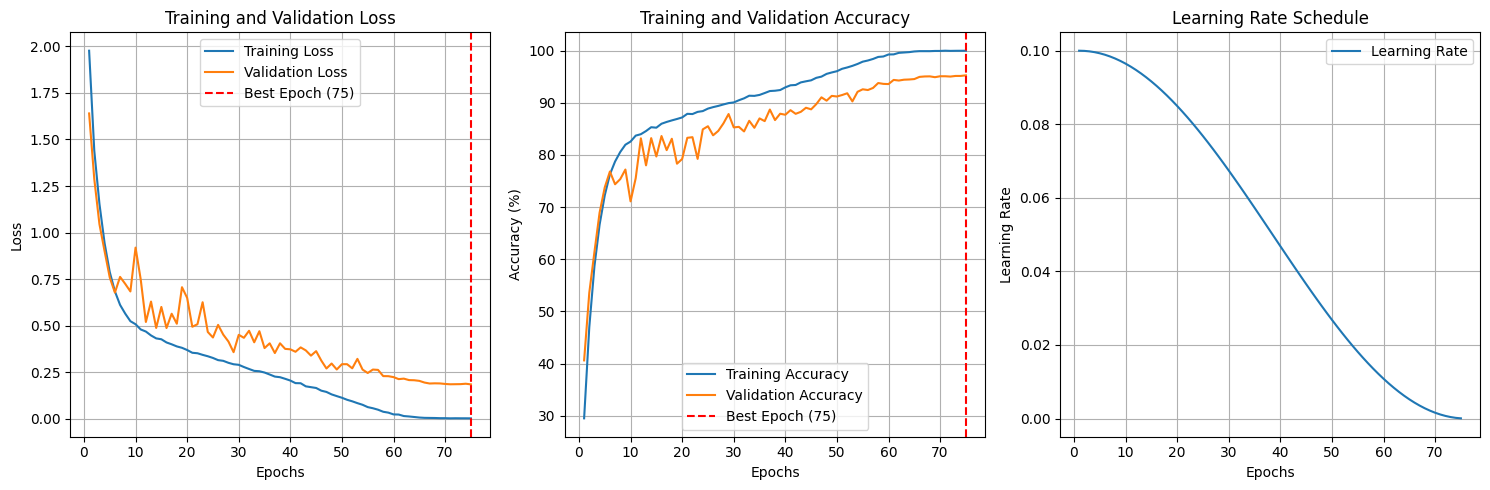

In [ ]:
print("\n--- Plotting Training and Validation Metrics ---")  # Cetak informasi bahwa plotting akan dilakukan
epochs_range = range(1, len(train_losses_hist) + 1)  # Buat range epoch dari 1 sampai jumlah epoch yang tercatat

plt.figure(figsize=(15, 5))  # Buat figure dengan ukuran lebar 15 dan tinggi 5 inch

plt.subplot(1, 3, 1)  # Buat subplot pertama dari 3 kolom di 1 baris (plot loss)
plt.plot(epochs_range, train_losses_hist, label='Training Loss')  # Plot loss training per epoch
plt.plot(epochs_range, val_losses_hist, label='Validation Loss')  # Plot loss validation per epoch
if best_epoch_num > 0 and best_epoch_num <= len(epochs_range):  # Jika ada epoch terbaik valid
    plt.axvline(x=best_epoch_num, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_num})')  # Garis vertikal merah untuk best epoch
plt.xlabel('Epochs')  # Label sumbu-x
plt.ylabel('Loss')  # Label sumbu-y
plt.title('Training and Validation Loss')  # Judul subplot
plt.legend()  # Tampilkan legenda
plt.grid(True)  # Tampilkan grid

plt.subplot(1, 3, 2)  # Buat subplot kedua (plot accuracy)
plt.plot(epochs_range, train_accs_hist, label='Training Accuracy')  # Plot akurasi training
plt.plot(epochs_range, val_accs_hist, label='Validation Accuracy')  # Plot akurasi validation
if best_epoch_num > 0 and best_epoch_num <= len(epochs_range):
    plt.axvline(x=best_epoch_num, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_num})')  # Garis vertikal best epoch
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)  # Buat subplot ketiga (plot learning rate)
plt.plot(epochs_range, learning_rates_hist, label='Learning Rate')  # Plot perubahan learning rate tiap epoch
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Atur tata letak supaya subplot tidak saling tumpang tindih
plt.show()  # Tampilkan plot


1. Plot "Training and Validation Loss"
  * Garis biru (Training Loss): Menunjukkan bahwa loss di data pelatihan terus menurun secara konsisten dari awal hingga akhir epoch — menandakan model belajar dengan baik dari data training.
  * Garis oranye (Validation Loss): Turun drastis di awal, kemudian mengalami fluktuasi kecil namun tetap stabil turun hingga akhir.
  * Garis merah putus-putus menandakan "Best Epoch (75)", yaitu epoch di mana model mencapai performa terbaik pada data validasi.
  * Model tidak overfitting karena training loss dan validation loss sama-sama menurun, dan jaraknya tetap kecil hingga akhir pelatihan. Ini menunjukkan generalisasi yang baik.
2. Plot "Training and Validation Accuracy"
  * Training Accuracy (biru) terus meningkat dan mendekati 100%, menunjukkan model sangat memahami data latih.
  * Validation Accuracy (oranye) juga meningkat, mencapai sekitar 94% di akhir, tanpa penurunan drastis.
  * Model tidak mengalami overfitting yang signifikan karena akurasi validasi juga meningkat dan tetap mendekati akurasi training.
3. Plot "Learning Rate Schedule"
  * Garis ini menunjukkan penurunan nilai learning rate secara bertahap dari 0.1 menjadi mendekati 0 sepanjang 75 epoch.

# Confussion Matrix

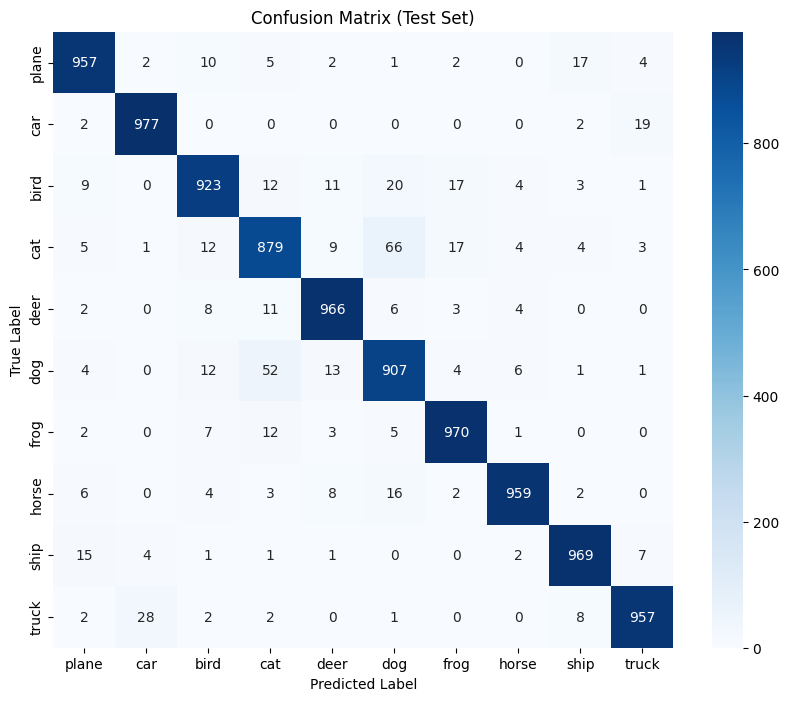

In [ ]:
# --- Confusion Matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Akurasi

In [ ]:
print("\n--- Final Accuracy Summary ---")
print(f"Train Accuracy (last epoch): {epoch_train_acc:.2f}%")
print(f"Validation Accuracy (best):  {best_val_accuracy:.2f}%")
print(f"Test Accuracy (final):       {final_test_acc:.2f}%")



--- Final Accuracy Summary ---
Train Accuracy (last epoch): 99.97%
Validation Accuracy (best):  95.26%
Test Accuracy (final):       94.64%


**Training Accuracy (99.97%):**

Sebanyak 99.97% dari data pelatihan berhasil diklasifikasikan dengan benar oleh model. Ini menunjukkan bahwa model telah belajar sangat baik dari data pelatihan.

**Validation Accuracy (95.26%):**

Selama proses pelatihan, model mencapai akurasi 95.26% pada data validasi. Artinya, model dapat mengeneralisasi sangat baik ke data yang belum pernah dilihat sebelumnya.

**Test Accuracy (94.26):**

Pada data uji akhir, model mencapai akurasi 94.26. Ini menandakan performa yang stabil dan kuat, dengan kemampuan klasifikasi yang konsisten di luar data pelatihan.

**Kesimpulan:**

Perbedaan kecil antara training, validation, dan test accuracy menunjukkan model tidak mengalami overfitting secara signifikan.
Model memiliki kemampuan generalisasi yang baik untuk dataset CIFAR-10.


# Analisis feature map


Prediksi Benar:


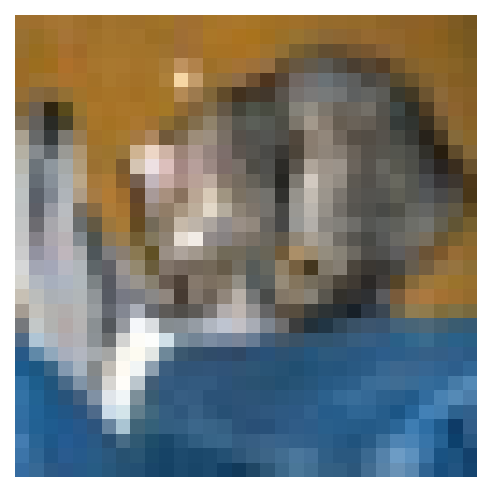

Ground Truth: cat             Predicted: cat            


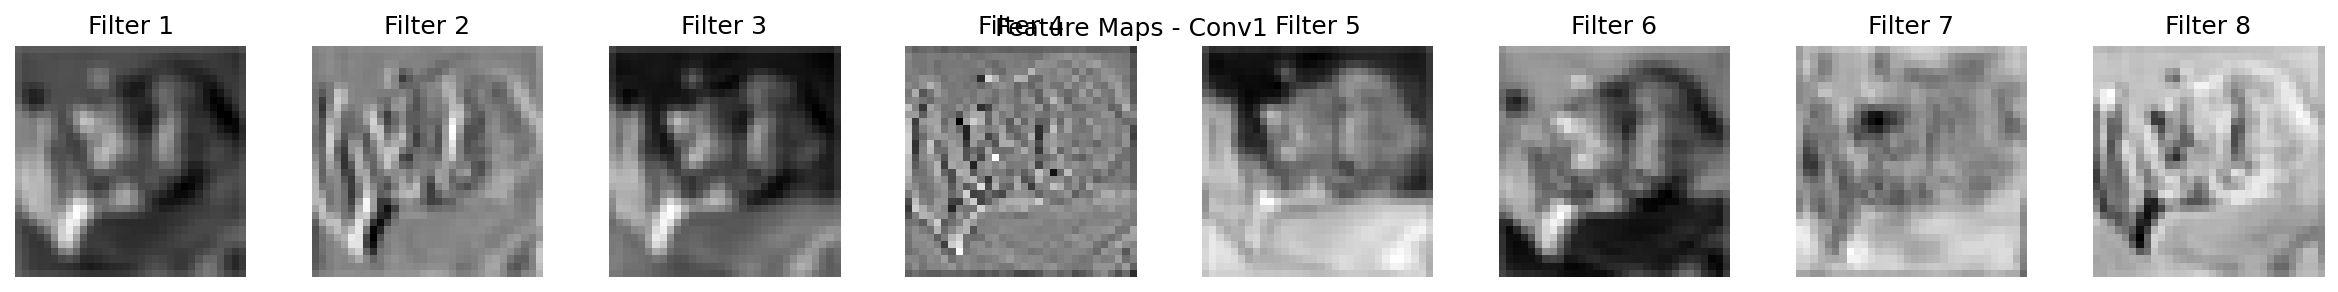

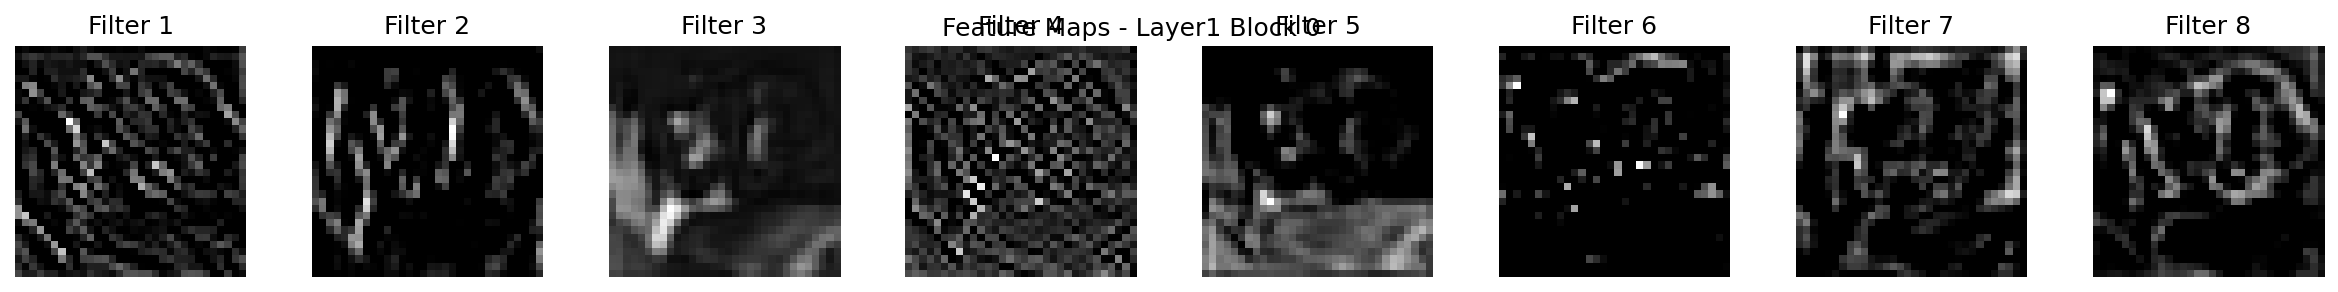

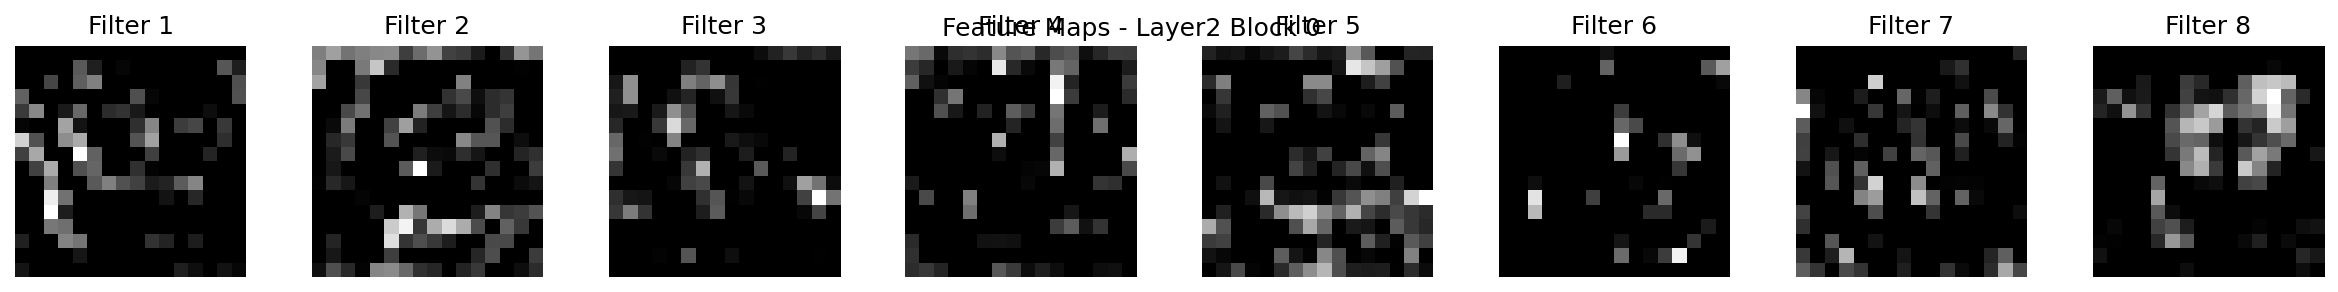

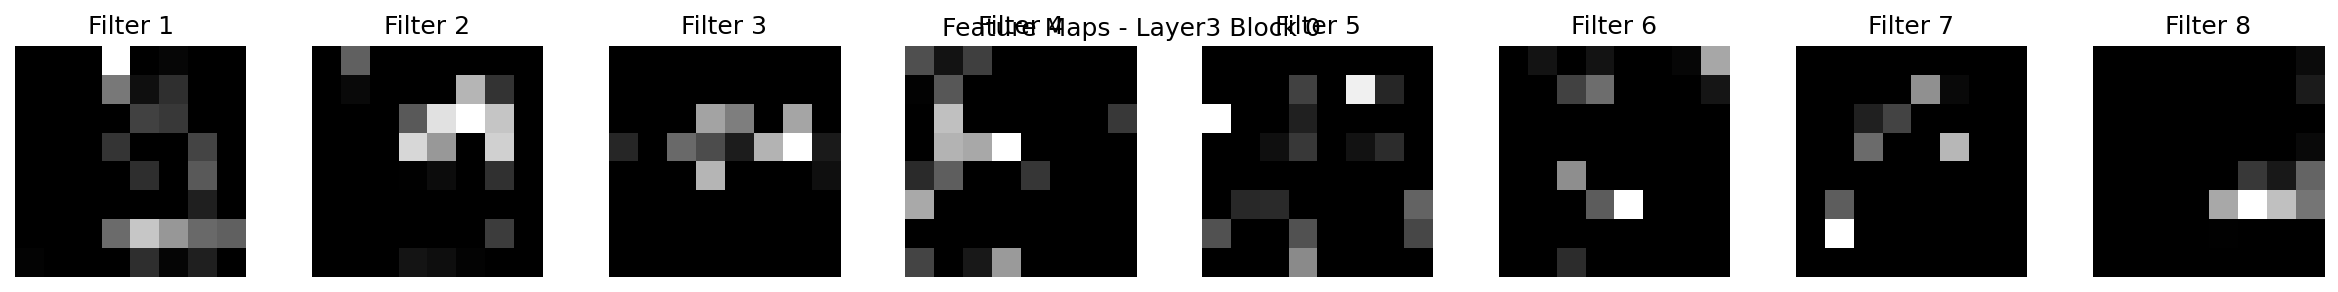

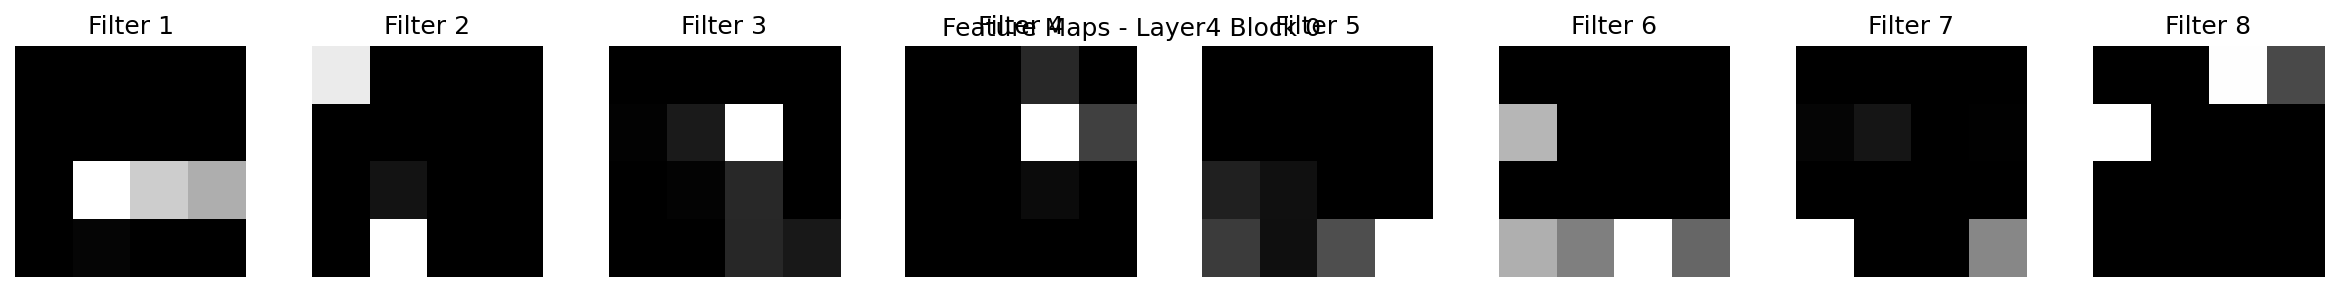

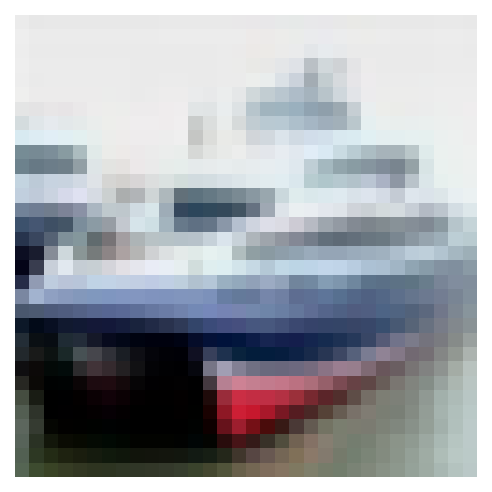

Ground Truth: ship            Predicted: ship           


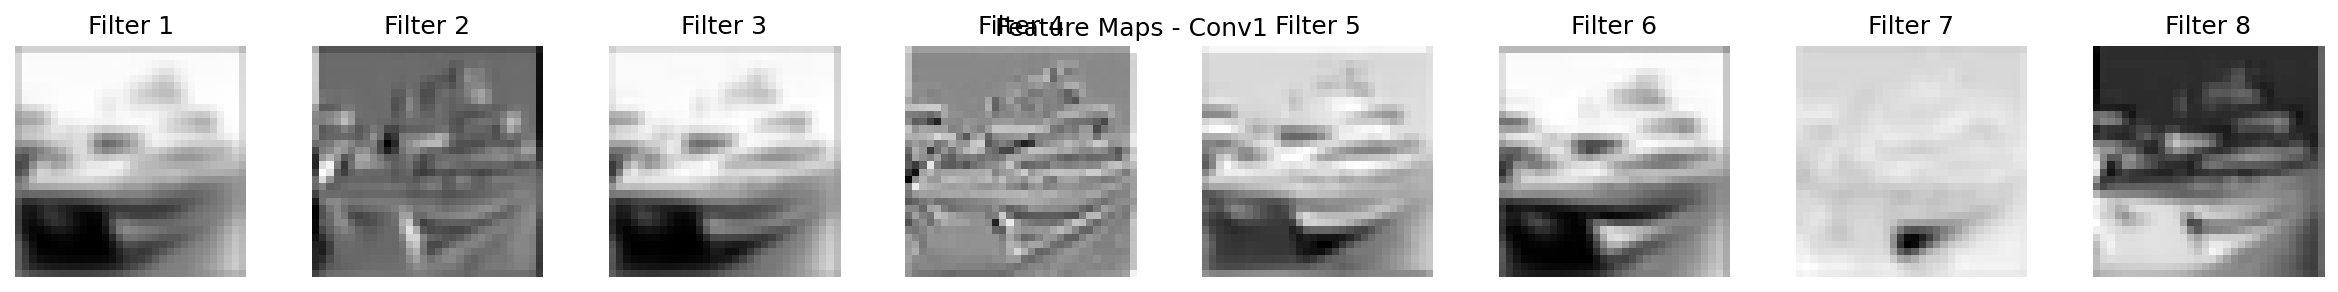

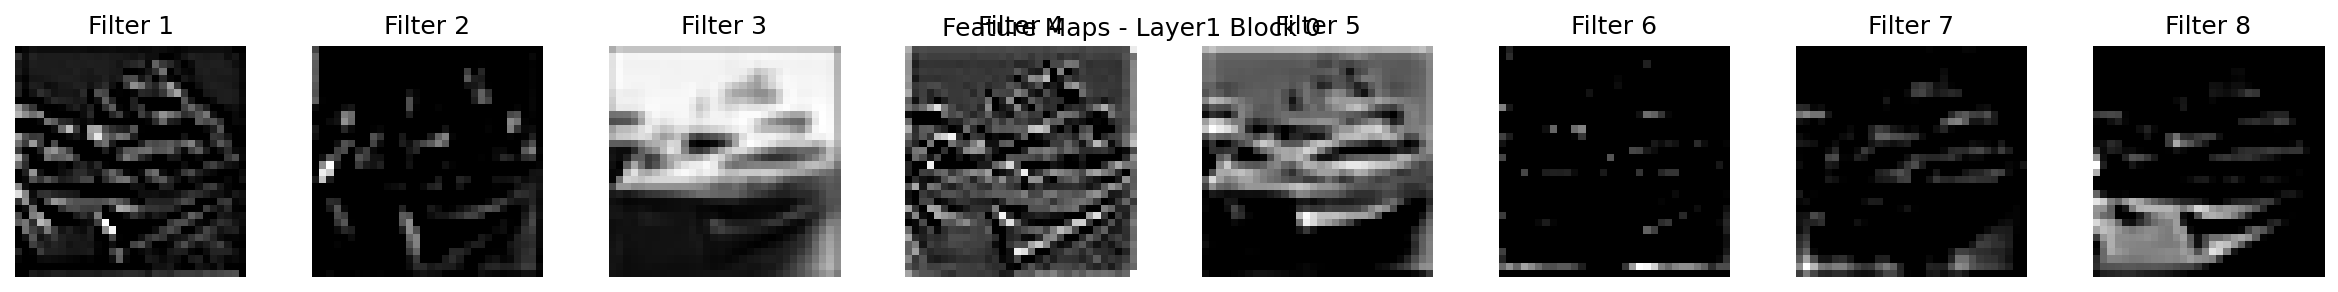

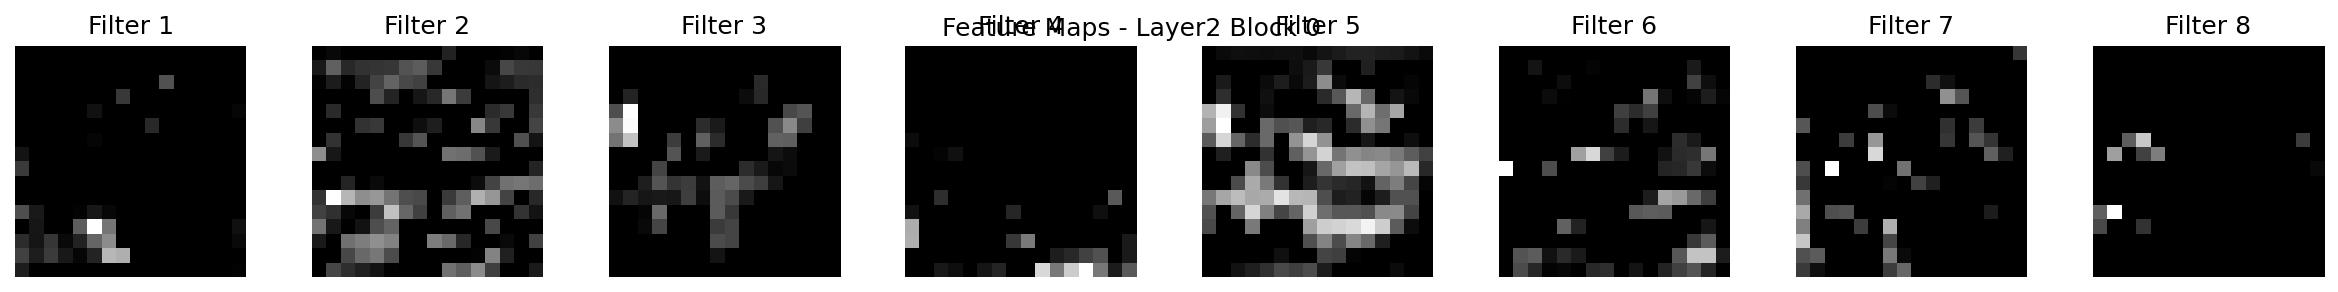

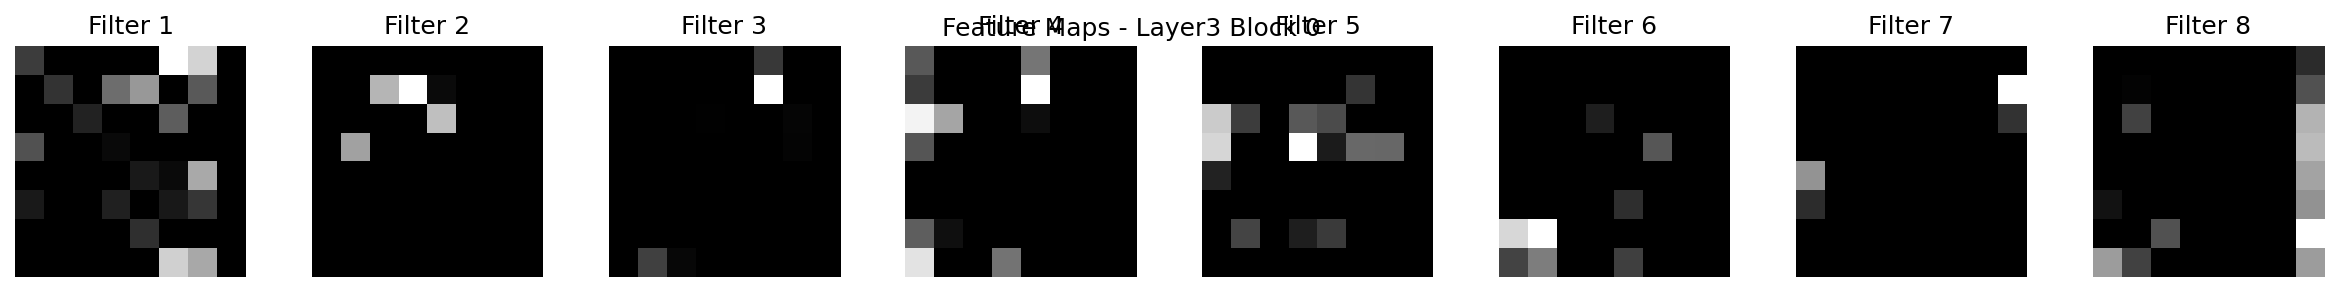

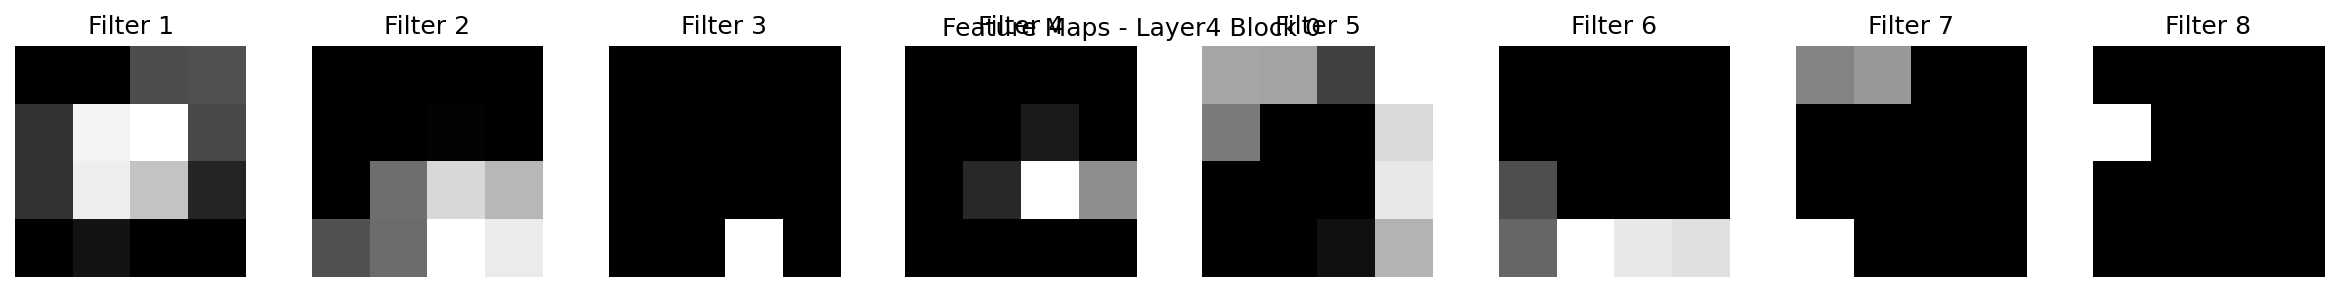


Prediksi Salah:


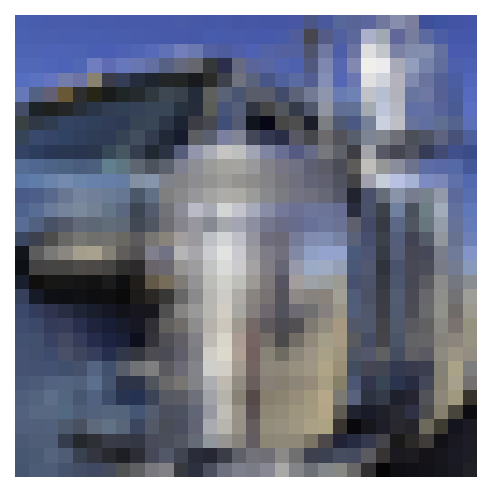

Ground Truth: truck           Predicted: ship           


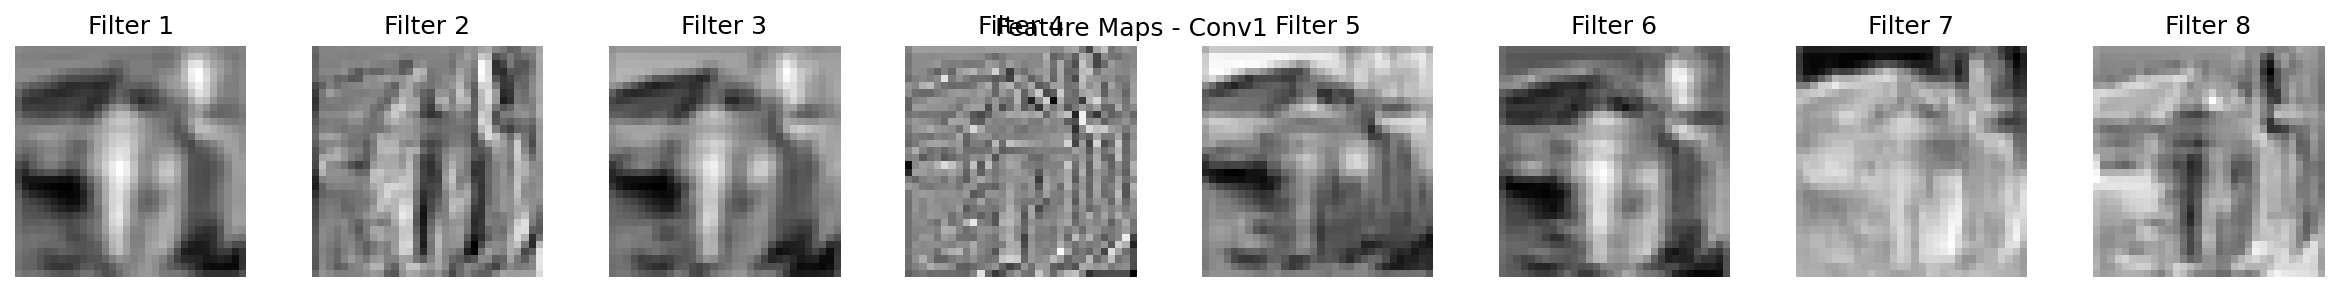

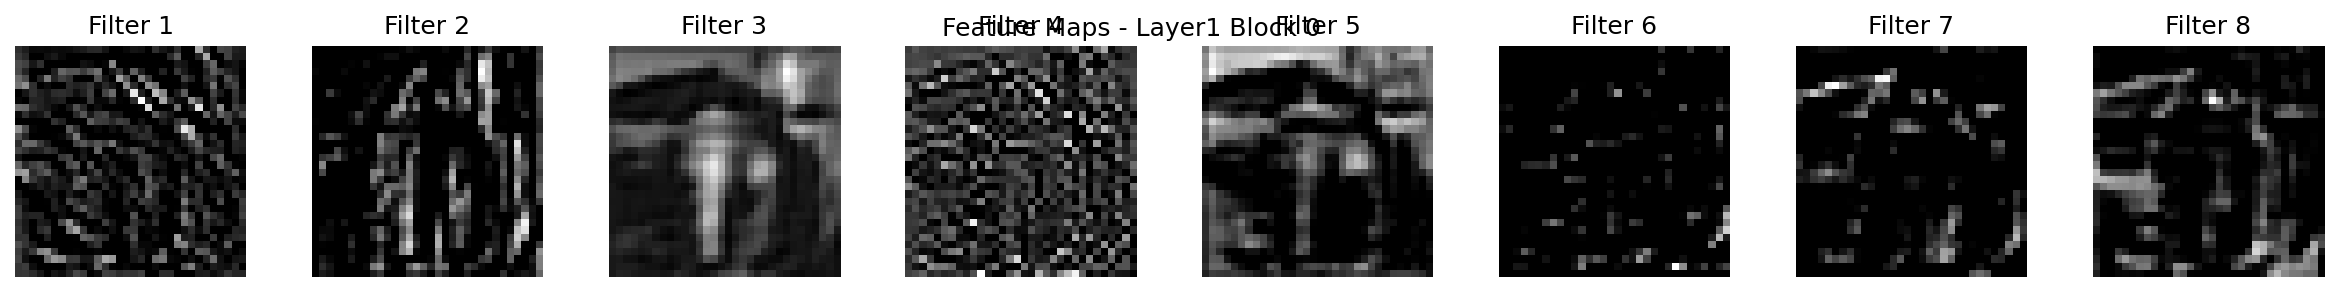

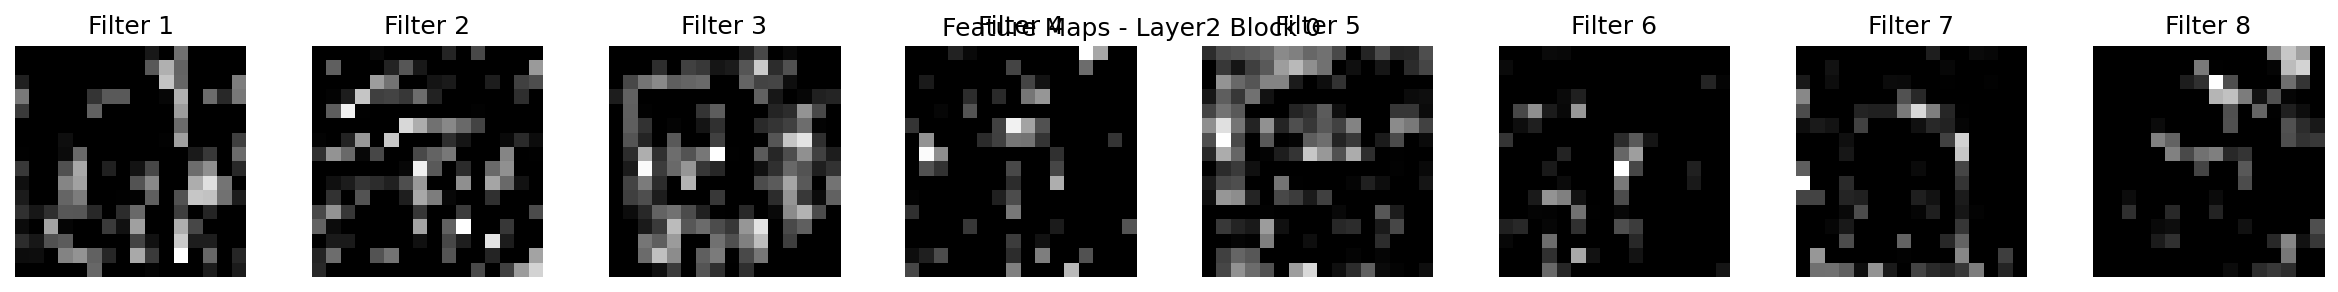

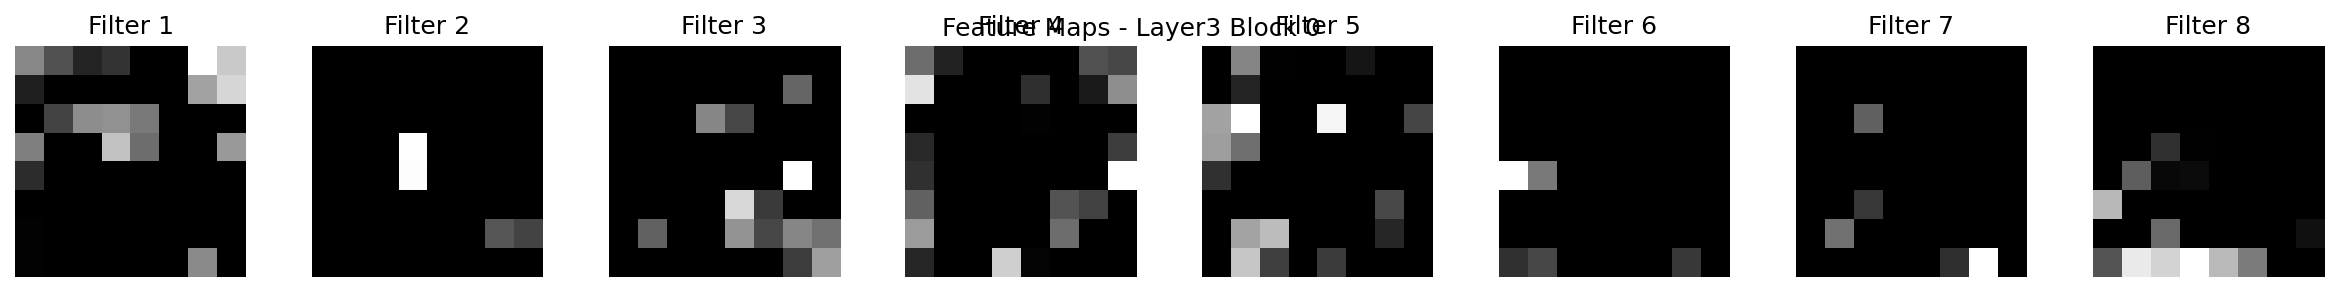

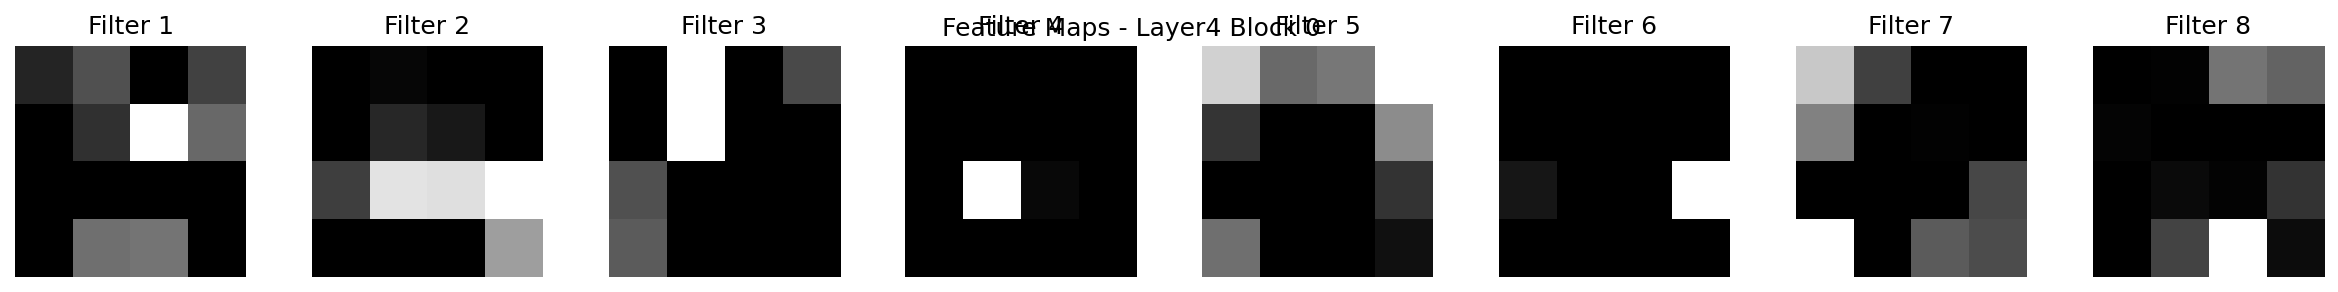

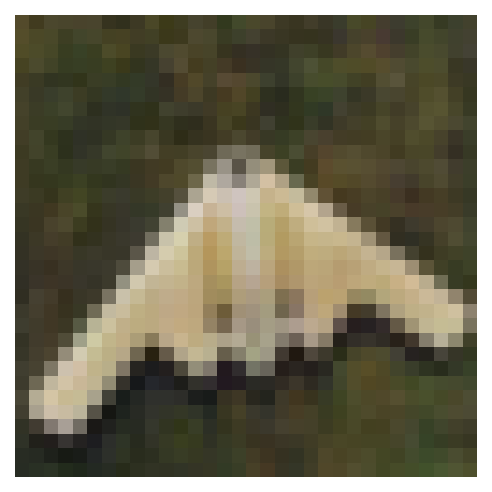

Ground Truth: plane           Predicted: dog            


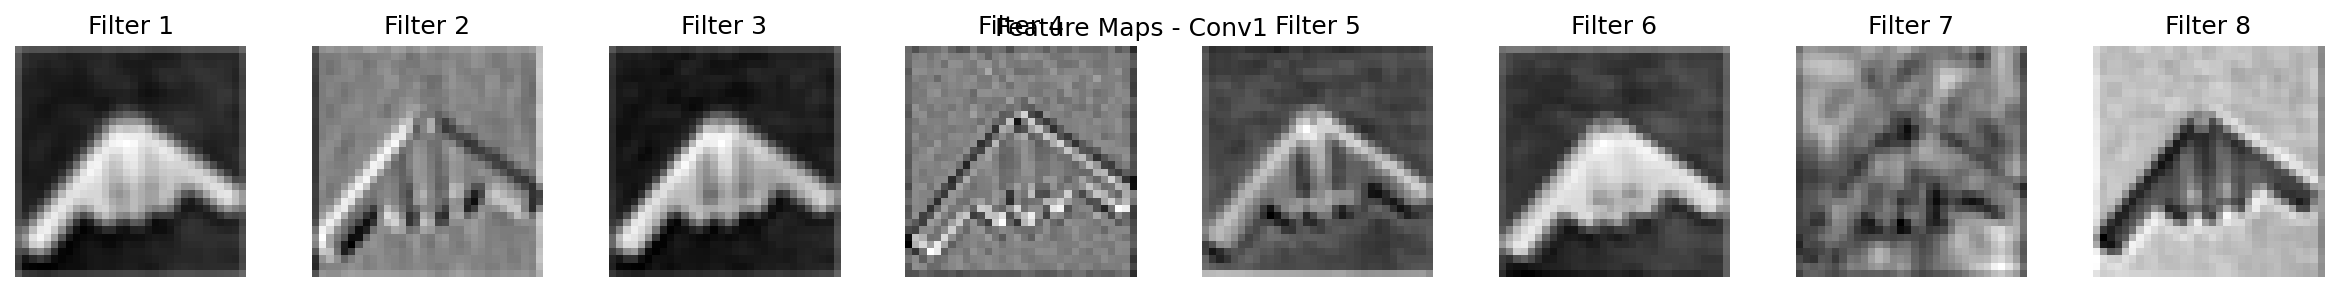

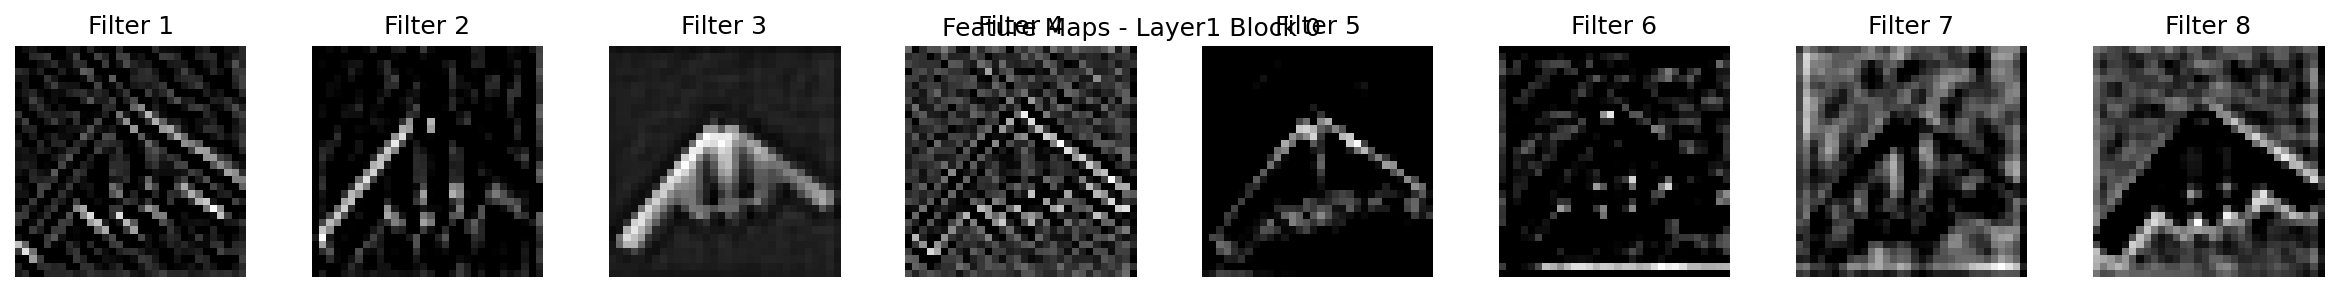

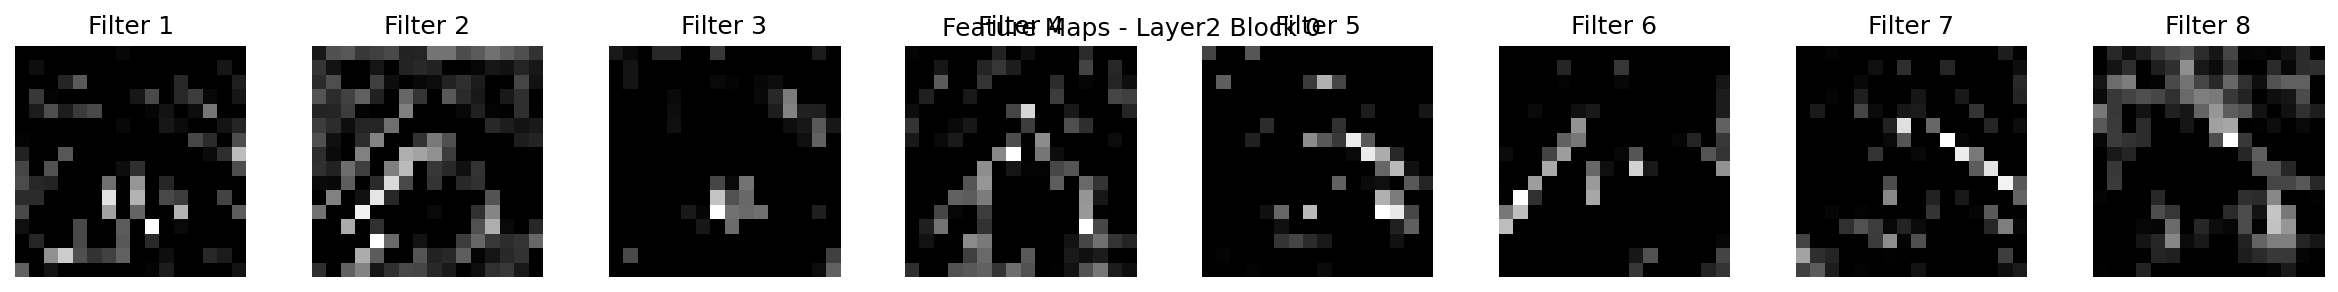

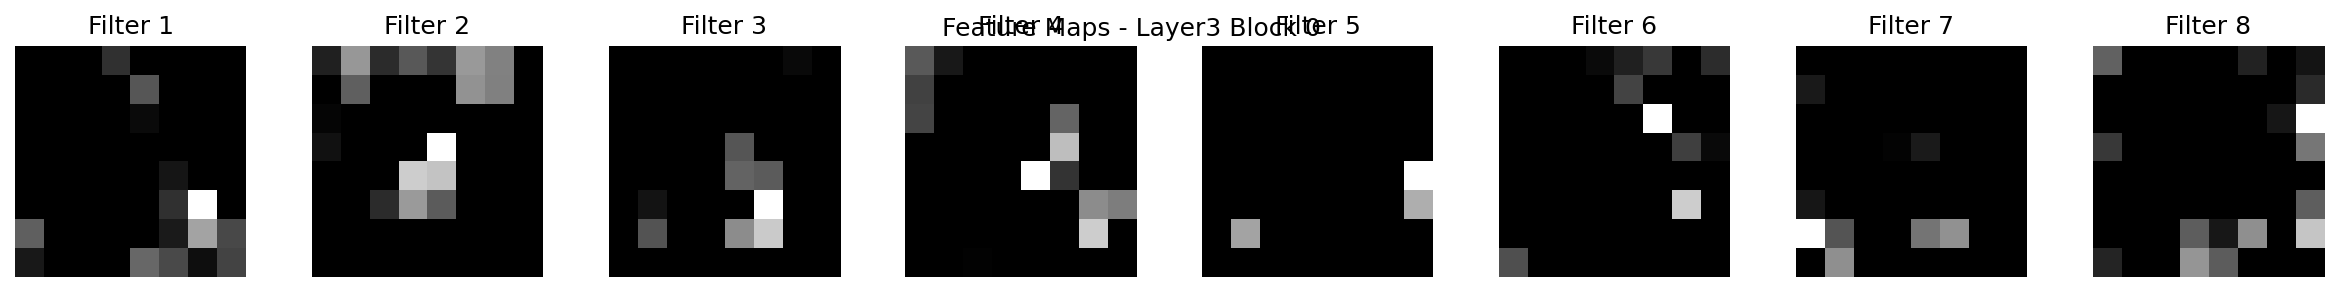

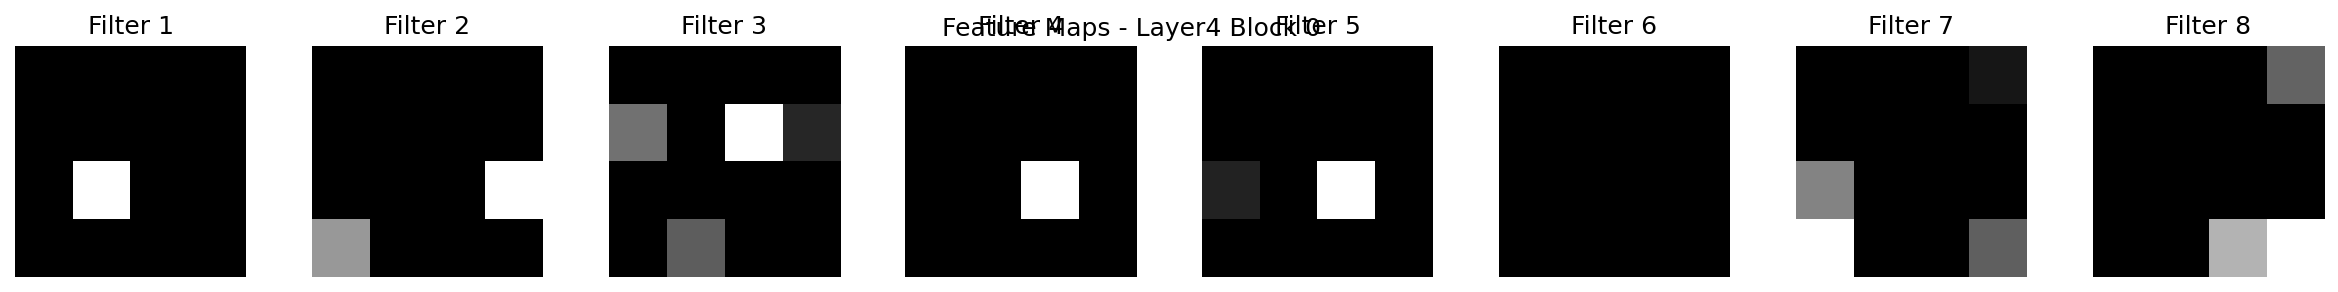

In [ ]:
# Tingkatkan DPI untuk visualisasi lebih tajam
plt.rcParams['figure.dpi'] = 150

# Fungsi untuk unnormalize dan menampilkan gambar
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')
    plt.show()

# Fungsi untuk menampilkan feature maps
def show_feature_maps(feature_maps, layer_name, num_filters=8):
    feature_maps = feature_maps.cpu().numpy()
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min() + 1e-8)
    fig, axes = plt.subplots(1, num_filters, figsize=(20, 2))
    for i in range(min(num_filters, feature_maps.shape[1])):
        axes[i].imshow(feature_maps[0, i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i+1}')
    plt.suptitle(f'Feature Maps - {layer_name}')
    plt.show()

# Hook untuk menangkap feature maps
feature_maps = {}
def get_feature_maps(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach()
    return hook

# Set model ke evaluasi
resnet.eval()

# Daftar kelas CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Hook pada layer penting ResNet
resnet.conv1.register_forward_hook(get_feature_maps('conv1'))
resnet.layer1[0].register_forward_hook(get_feature_maps('layer1_0'))
resnet.layer2[0].register_forward_hook(get_feature_maps('layer2_0'))
resnet.layer3[0].register_forward_hook(get_feature_maps('layer3_0'))
resnet.layer4[0].register_forward_hook(get_feature_maps('layer4_0'))

# Ambil batch dari testloader
dataiter = iter(testloader)
try:
    images, labels = next(dataiter)
except StopIteration:
    print("Test loader is empty.")
    images, labels = None, None

if images is not None:
    images_to_device = images.to(device)
    labels_to_device = labels.to(device)
    with torch.no_grad():
        outputs = resnet(images_to_device)
        _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu()
    labels = labels.cpu()

    correct_idx = (predicted == labels).nonzero(as_tuple=True)[0]
    incorrect_idx = (predicted != labels).nonzero(as_tuple=True)[0]

    if len(correct_idx) > 0:
        print("\nPrediksi Benar:")
        for idx in correct_idx[:2]:
            img = images[idx]
            imshow(img)
            print(f'Ground Truth: {classes[labels[idx]]:<15s} Predicted: {classes[predicted[idx]]:<15s}')
            with torch.no_grad():
                _ = resnet(img.unsqueeze(0).to(device))
            show_feature_maps(feature_maps['conv1'], 'Conv1', num_filters=8)
            show_feature_maps(feature_maps['layer1_0'], 'Layer1 Block 0', num_filters=8)
            show_feature_maps(feature_maps['layer2_0'], 'Layer2 Block 0', num_filters=8)
            show_feature_maps(feature_maps['layer3_0'], 'Layer3 Block 0', num_filters=8)
            show_feature_maps(feature_maps['layer4_0'], 'Layer4 Block 0', num_filters=8)

    if len(incorrect_idx) > 0:
        print("\nPrediksi Salah:")
        for idx in incorrect_idx[:2]:
            img = images[idx]
            imshow(img)
            print(f'Ground Truth: {classes[labels[idx]]:<15s} Predicted: {classes[predicted[idx]]:<15s}')
            with torch.no_grad():
                _ = resnet(img.unsqueeze(0).to(device))
            show_feature_maps(feature_maps['conv1'], 'Conv1', num_filters=8)
            show_feature_maps(feature_maps['layer1_0'], 'Layer1 Block 0', num_filters=8)
            show_feature_maps(feature_maps['layer2_0'], 'Layer2 Block 0', num_filters=8)
            show_feature_maps(feature_maps['layer3_0'], 'Layer3 Block 0', num_filters=8)
            show_feature_maps(feature_maps['layer4_0'], 'Layer4 Block 0', num_filters=8)
else:
    print("Tidak ada data untuk divisualisasikan.")


**Ground Truth: cat | Predicted: cat**

Model ResNet18 yang telah dimodifikasi berhasil mengklasifikasikan gambar dengan benar sebagai "cat", yang menunjukkan bahwa proses ekstraksi fitur bekerja efektif. Visualisasi ini menampilkan aktivasi dari beberapa filter di berbagai layer convolutional:
*   **Layer Conv1 (Baris Pertama)**
  * Gambar Teratas (baris pertama) menunjukkan hasil aktivasi dari lapisan konvolusi pertama (Conv1) pada delapan filter pertama.
  * Aktivasi di sini menunjukkan bahwa model mengenali struktur dasar seperti tepi, tekstur, dan gradasi terang-gelap.
  * Karena gambar input adalah kucing, bentuk wajah, telinga, atau bulu mungkin sudah mulai tampak samar.
*    **Layer1 (Baris kedua)**:
  * Di lapisan ini, filter mulai mendeteksi pola lokal yang lebih kompleks daripada sekadar tepi.
  * Kita bisa melihat bahwa beberapa filter mempertegas kontur berbulu dan bagian wajah.
  * Fitur masih relatif padat dan detail karena ukuran spasial masih besar.
*    **Layer2 (Baris kedua)**:
  * Di tahap ini, dimensi spasial menurun, tapi filter sudah fokus pada bagian penting dari objek.
  * Aktivasi terlihat lebih terfokus, dengan banyak area menjadi gelap (diabaikan) dan hanya bagian penting yang menyala.
  * Artinya, model mulai mengabaikan noise dan memperkuat ciri khas kucing.
*    **Layer3 (Baris ketiga)**:
  * Aktivasi semakin abstrak, dan hanya bagian tertentu dari gambar yang memiliki nilai aktivasi tinggi.
  * Biasanya di tahap ini, model belajar komponen bentuk seperti mata, telinga, atau posisi kepala kucing, bukan piksel individu.
*    **Layer4 (Baris keempat)**:
  * Aktivasi hampir seperti peta perhatian, di mana hanya bagian yang paling penting dari gambar yang ditonjolkan.
  * Gambar menunjukkan area sangat terfokus, menandakan bahwa model sudah melakukan abstraksi maksimal sebelum klasifikasi.

**Kesimpulan:**

* Ground Truth dan Prediksi sama-sama “cat”, dan fitur yang diaktifkan menunjukkan bahwa model benar-benar memfokuskan diri pada karakteristik khas seekor kucing.
* Aktivasi pada lapisan akhir sangat spesifik dan menunjukkan kepercayaan model yang tinggi terhadap fitur-fitur penting, seperti kontur wajah, telinga, atau mata kucing.
* Hal ini merupakan indikator positif bahwa ResNet18 telah berhasil mempelajari representasi internal yang relevan untuk tugas klasifikasi.

**Ground Truth: plane | Predicted: dog**


Model ResNet18 yang telah dimodifikasi gagal mengklasifikasikan gambar "plane" sebagai "dog"
*   **Layer Conv1 (Baris Pertama)**
  * Aktivasi kuat di sekitar sayap dan badan pesawat — tepi-tepi diagonal dan horizontal terlihat jelas.
  * Deteksi awal cukup baik: fitur pesawat terlihat jelas.
* Layer1 - Layer2:
  * Beberapa filter masih mempertahankan bentuk sayap dan badan pesawat.
  * Namun, mulai terlihat aktivasi noise atau ambigu, terutama pada latar belakang dan bentuk-bentuk yang kurang khas pesawat.
* Layer3 - Layer4:
  * Fitur makin menyempit pada area kecil yang tidak mewakili pesawat secara kuat.
  * Beberapa filter mengaktifkan bagian yang bisa disalahartikan sebagai fitur anjing (misalnya, lengkungan seperti telinga atau bentuk tubuh melengkung).

**Kemungkinan Penyebab Misprediksi:**
* Model kehilangan representasi khas pesawat di layer yang lebih dalam.
* Terdapat kemiripan struktural antara gambar pesawat ini dan fitur umum anjing (bisa jadi background atau pose).
* Kemungkinan overfitting pada data anjing atau underrepresentation kelas pesawat di data pelatihan.
